In [2]:
import numpy as np
from geo_tool import Point_Cloud
from geo_tool.point_clouds.aux import unit_cube_grid_point_cloud

from general_tools.clustering.convenience import find_nearest_neighbors
from scipy.spatial.distance import cdist
from tf_lab.iclr.helper import load_multiple_version_of_pcs

from sklearn.neighbors import KernelDensity

In [3]:
%matplotlib inline

In [4]:
top_data_dir = '/orions4-zfs/projects/optas/DATA/'
syn_id = '03001627'
in_data = load_multiple_version_of_pcs('uniform_one', syn_id, n_classes=1)

679 pclouds were loaded. They belong in 1 shape-classes.
5761 pclouds were loaded. They belong in 1 shape-classes.
338 pclouds were loaded. They belong in 1 shape-classes.


In [5]:
def global_cutoff_antipc(gt_points, ambient_space, threshold=1.0):
    _, n1_dists = find_nearest_neighbors(gt_points, k=1)
    max_min = np.max(n1_dists)
    k_ids, k_dists = find_nearest_neighbors(ambient_space, gt_points, 1)   # match each point in sphere to GT
    
    far_enough = k_dists > threshold * max_min
    legit_dists = k_dists[far_enough]
    n_gt = len(gt_poins)
    ok_sorted = np.argsort(legit_dists)[:n_gt] # pick legit points with smallest dist from sphere to GT
    idx = np.arange(len(k_ids))
    final_ids = idx[np.hstack(far_enough)][ok_sorted]
    anti_points = ambient_space[final_ids]
    return anti_points

def neighborhood_based_anti_pc(gt_points, ambient_space, k=10):    
    _, n1_dists = find_nearest_neighbors(gt_points, k=k)
    max_min = np.max(n1_dists, 1)
    n_gt = len(gt_points)
    found = np.zeros(n_gt, dtype=np.int32)
    d_mat = cdist(gt_points, ambient_space)
    
    for i in xrange(n_gt):
        temp = d_mat[i]
        temp[d_mat[i] > max_min[i]] = np.Inf
        found[i] = np.argmin(temp)
    anti_points = ambient_space[found]
    return anti_points

def density_features(gt_points, k=10):
    _, n1_dists = find_nearest_neighbors(gt_points, k=k)
    max_min = np.max(n1_dists, 1)
    return max_min

In [6]:
k = KernelDensity(kernel='gaussian', bandwidth=1, leaf_size=20)

5395


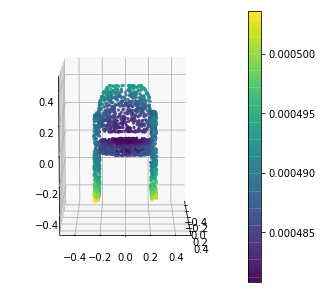

In [8]:
rid = np.random.randint(in_data['train'].num_examples)
print rid
true_points = in_data['train'].point_clouds[rid]
pc = Point_Cloud(true_points.astype(np.float32))
pc.center_in_unit_sphere()
pc_points = pc.points

k.fit(pc_points)
c = k.score_samples(pc_points)
# Point_Cloud(pc_points).plot(s=0.5, azim=0)
# c = density_features(pc_points, 10)
c /= np.sum(c)
Point_Cloud(pc_points).plot(azim=0, s=20, c=c, color='w');

In [9]:
def plot_gt_and_anti(pc_points, anti_points):
    all_points = np.vstack((pc_points, anti_points))
    c = np.ones(len(all_points)) * 100
    c[:len(pc_points)] = 5
    fig = Point_Cloud(all_points).plot(in_u_sphere=True, s=10, c=c, azim=0, color='white')
    return fig

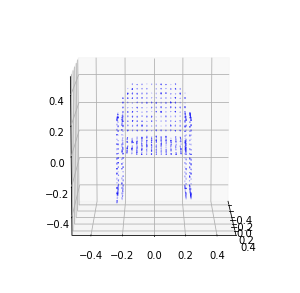

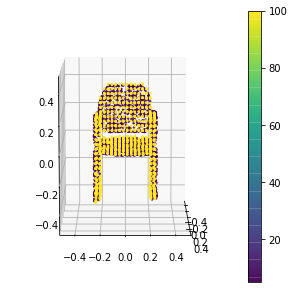

In [12]:
voxel_res = 32
ambient_space = unit_cube_grid_point_cloud(voxel_res, clip_sphere=True)[0]
anti_points = neighborhood_based_anti_pc(pc_points, ambient_space)
Point_Cloud(anti_points).plot(azim=0, s=0.05);
plot_gt_and_anti(pc_points, anti_points);

In [2]:
%matplotlib

Using matplotlib backend: TkAgg


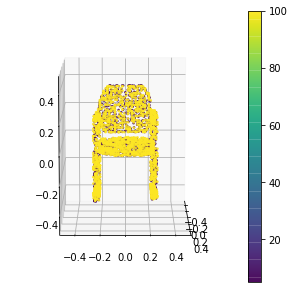

In [11]:
f = plot_gt_and_anti(pc_points, anti_points);

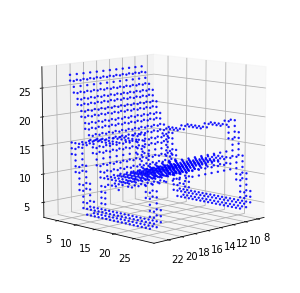

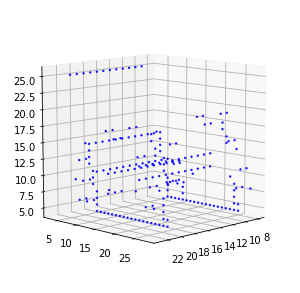

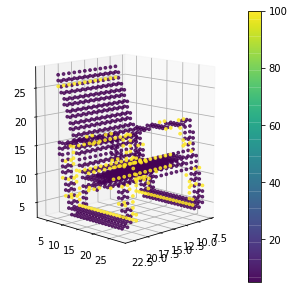

In [13]:
## ATEMPT with Free-space of Distance-Fields
from pc_completions.distance_fields import load_unsigned_distance_field

in_f = '/scr/optas/DATA/Distance_Fields/shapenet_dim32_df/03001627/1033ee86cc8bac4390962e4fb7072b86__0__.df'
in_df = load_unsigned_distance_field(in_f)

min_prc = 0
max_prc = 0.5
tf = in_df.copy()
tf[np.logical_or(tf < min_prc,  tf > max_prc)] = 0
x, y, z = np.where(tf)
true_points = np.vstack((z, y, x)).T
Point_Cloud(true_points).plot(in_u_sphere=False, azim=45);

min_prc = 0.6
max_prc = 0.7
ff = in_df.copy()
ff[np.logical_or(ff < min_prc,  ff > max_prc)] = 0
x, y, z = np.where(ff)
false_points = np.vstack((z, y, x)).T
Point_Cloud(false_points).plot(in_u_sphere=False, azim=45);

all_points = np.vstack((true_points, false_points))
c = np.ones(len(all_points)) * 100
c[:len(true_points)] = 5
Point_Cloud(all_points).plot(in_u_sphere=False, c=c, s=30, azim=45);